# COMP579 Assignment 2

**Coding: Tabular RL [70 points]**

In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from gym.wrappers import StepAPICompatibility
import pickle
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def softmax(x, temp):
    z = np.exp(x/temp - np.max(x/temp))
    return z/np.sum(z)

In [4]:
class Sarsa:
    def __init__(self, env, alpha, gamma, temp):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.temp = temp
        self.n_states = env.observation_space.n
        self.n_actions = env.action_space.n
        self.Q = np.zeros((self.n_states, self.n_actions))

    def select_action(self, s, greedy=False):
        if greedy:
            return np.argmax(self.Q[s])
        probs = softmax(self.Q[s], self.temp)
        return np.random.choice(self.n_actions, p=probs)

    def update(self, s, a, r, s_prime, a_prime, done):
        target = r
        if not done:
            target += self.gamma * self.Q[s_prime, a_prime]
        self.Q[s, a] += self.alpha * (target - self.Q[s, a])


class ExpectedSarsa:
    def __init__(self, env, alpha, gamma, temp):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.temp = temp
        self.n_states = env.observation_space.n
        self.n_actions = env.action_space.n
        self.Q = np.zeros((self.n_states, self.n_actions))

    def select_action(self, s, greedy=False):
        if greedy:
            return np.argmax(self.Q[s])
        probs = softmax(self.Q[s], self.temp)
        return np.random.choice(self.n_actions, p=probs)

    def update(self, s, a, r, s_prime, a_prime, done):
        if done:
            exp_val = 0
        else:
            probs = softmax(self.Q[s_prime], self.temp)
            exp_val = np.dot(self.Q[s_prime], probs)
        target = r + self.gamma * exp_val
        self.Q[s, a] += self.alpha * (target - self.Q[s, a])

# bonus question, optional
class Hybrid_Sarsa_Q:
  def __init__(self, env, alpha, gamma, temp):
    # write your solution here
    self.env = None
    self.alpha = None
    self.gamma = None
    self.temp = None
    self.Q = None
    return

  def select_action(self, s, greedy=False):
    # write your solution here
    if greedy:
      # if finished training, then choose the optimal policy
      return
    else:
      return

  def update(self, s, a, r, s_prime, a_prime, done):
    # write your solution here
    return

## Write your experiment code below

In [5]:
env_name = 'FrozenLake-v1'
env = gym.make(env_name)
env = StepAPICompatibility(env, new_step_api=True)
print("Action space:", env.action_space)
print("State space:", env.observation_space)

Action space: Discrete(4)
State space: Discrete(16)


/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [6]:
def run_training_episode(agent, env):
    s = env.reset()
    a = agent.select_action(s, greedy=False)
    total_reward = 0
    while True:
        s_prime, r, done, truncated, _ = env.step(a)
        total_reward += r
        if done or truncated:
            agent.update(s, a, r, s_prime, None, True)
            break
        a_prime = agent.select_action(s_prime, greedy=False)
        agent.update(s, a, r, s_prime, a_prime, False)
        s, a = s_prime, a_prime
    return total_reward

def run_test_episode(agent, env):
    s = env.reset()
    total_reward = 0
    while True:
        a = agent.select_action(s, greedy=True)
        s, r, done, truncated, _ = env.step(a)
        total_reward += r
        if done or truncated:
            break
    return total_reward

def run_trial(agent_class, alpha, gamma, temp, env, n_segments, n_train):
    agent = agent_class(env, alpha, gamma, temp)
    train_rewards = []
    test_rewards = []
    for _ in range(n_segments):
        seg_rewards = []
        for _ in range(n_train):
            seg_rewards.append(run_training_episode(agent, env))
        train_rewards.append(np.mean(seg_rewards))
        test_rewards.append(run_test_episode(agent, env))
    return train_rewards, test_rewards

In [16]:
# Hyperparameters
algorithms = {'Sarsa': Sarsa, 'ExpectedSarsa': ExpectedSarsa}
alphas = [0.1, 0.5, 0.9]
temps = [0.1, 0.5, 1.0]
n_trials = 10
n_segments = 500
n_train = 10
gamma = 1.0

In [17]:

results = {'Sarsa': {}, 'ExpectedSarsa': {}}

total_trials = 0

for alg_name, alg_class in algorithms.items():
    for alpha in alphas:
        for temp in temps:
            key = (alpha, temp)
            all_train, all_test = [], []
            for _ in range(n_trials):
                total_trials += 1
                print(f'Trial {total_trials} of {len(alphas)*len(temps)*2*n_trials}')
                tr, te = run_trial(alg_class, alpha, gamma, temp, env, n_segments, n_train)
                all_train.append(tr)
                all_test.append(te)
            avg_train = np.mean(all_train, axis=0)
            avg_test = np.mean(all_test, axis=0)
            final_train = np.mean([tr[-1] for tr in all_train])
            results[alg_name][key] = {'train': avg_train, 'test': avg_test, 'final_train': final_train, "all_train": all_train, "all_test": all_test}

with open('/content/drive/MyDrive/results.pkl', 'wb') as f:
    pickle.dump(results, f)


Trial 1 of 180


/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Trial 2 of 180
Trial 3 of 180
Trial 4 of 180
Trial 5 of 180
Trial 6 of 180
Trial 7 of 180
Trial 8 of 180
Trial 9 of 180
Trial 10 of 180
Trial 11 of 180
Trial 12 of 180
Trial 13 of 180
Trial 14 of 180
Trial 15 of 180
Trial 16 of 180
Trial 17 of 180
Trial 18 of 180
Trial 19 of 180
Trial 20 of 180
Trial 21 of 180
Trial 22 of 180
Trial 23 of 180
Trial 24 of 180
Trial 25 of 180
Trial 26 of 180
Trial 27 of 180
Trial 28 of 180
Trial 29 of 180
Trial 30 of 180
Trial 31 of 180
Trial 32 of 180
Trial 33 of 180
Trial 34 of 180
Trial 35 of 180
Trial 36 of 180
Trial 37 of 180
Trial 38 of 180
Trial 39 of 180
Trial 40 of 180
Trial 41 of 180
Trial 42 of 180
Trial 43 of 180
Trial 44 of 180
Trial 45 of 180
Trial 46 of 180
Trial 47 of 180
Trial 48 of 180
Trial 49 of 180
Trial 50 of 180
Trial 51 of 180
Trial 52 of 180
Trial 53 of 180
Trial 54 of 180
Trial 55 of 180
Trial 56 of 180
Trial 57 of 180
Trial 58 of 180
Trial 59 of 180
Trial 60 of 180
Trial 61 of 180
Trial 62 of 180
Trial 63 of 180
Trial 64 of 180


In [7]:
with open('/content/drive/MyDrive/results.pkl', 'rb') as f:
    results = pickle.load(f)

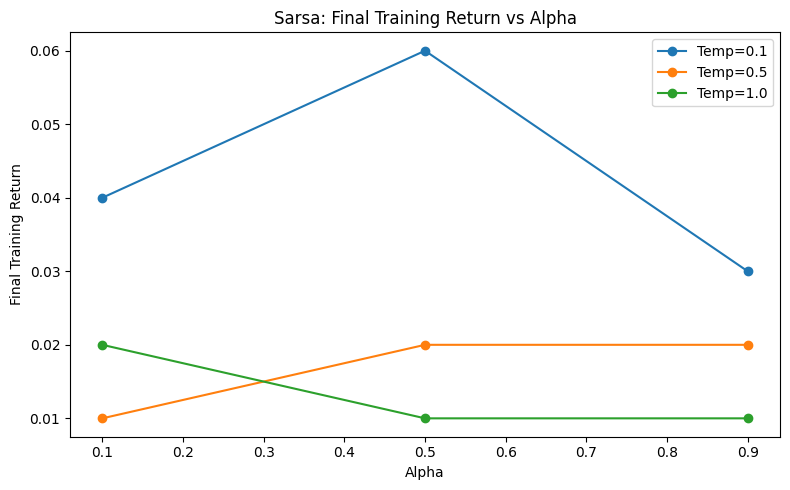

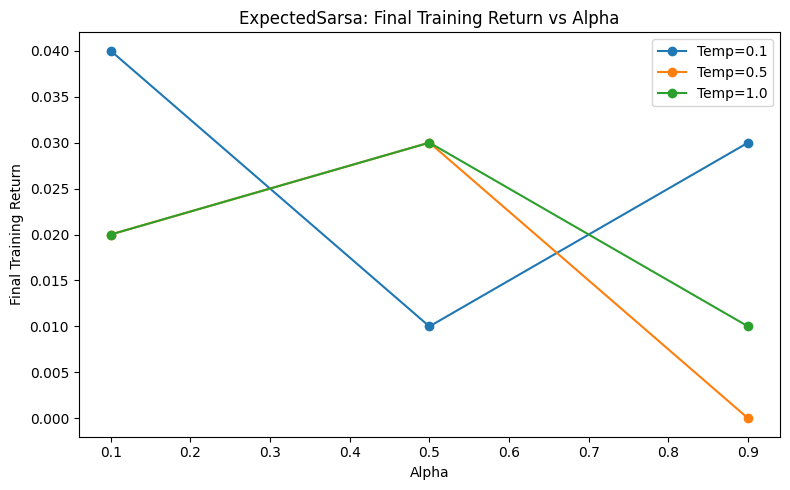

In [18]:
# Graph 1: Final training performance vs alpha (lines for different temperatures)
for alg_name in algorithms.keys():
    plt.figure(figsize=(8,5))
    for temp in temps:
        final_vals = []
        for alpha in alphas:
            final_vals.append(results[alg_name][(alpha, temp)]['final_train'])
        plt.plot(alphas, final_vals, marker='o', label=f'Temp={temp}')
    plt.xlabel('Alpha')
    plt.ylabel('Final Training Return')
    plt.title(f'{alg_name}: Final Training Return vs Alpha')
    plt.legend()
    plt.tight_layout()
    plt.show()


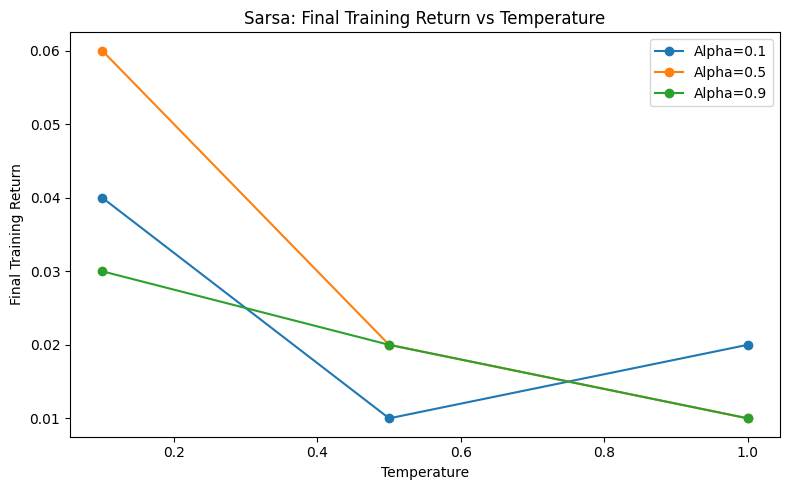

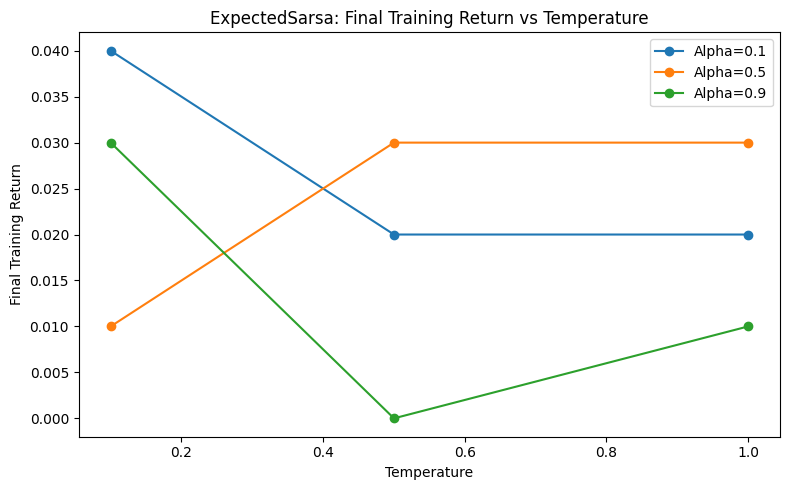

In [19]:
# Graph 2: Final training performance vs temperature (lines for different alphas)
for alg_name in algorithms.keys():
    plt.figure(figsize=(8,5))
    for alpha in alphas:
        final_vals = []
        for temp in temps:
            final_vals.append(results[alg_name][(alpha, temp)]['final_train'])
        plt.plot(temps, final_vals, marker='o', label=f'Alpha={alpha}')
    plt.xlabel('Temperature')
    plt.ylabel('Final Training Return')
    plt.title(f'{alg_name}: Final Training Return vs Temperature')
    plt.legend()
    plt.tight_layout()
    plt.show()


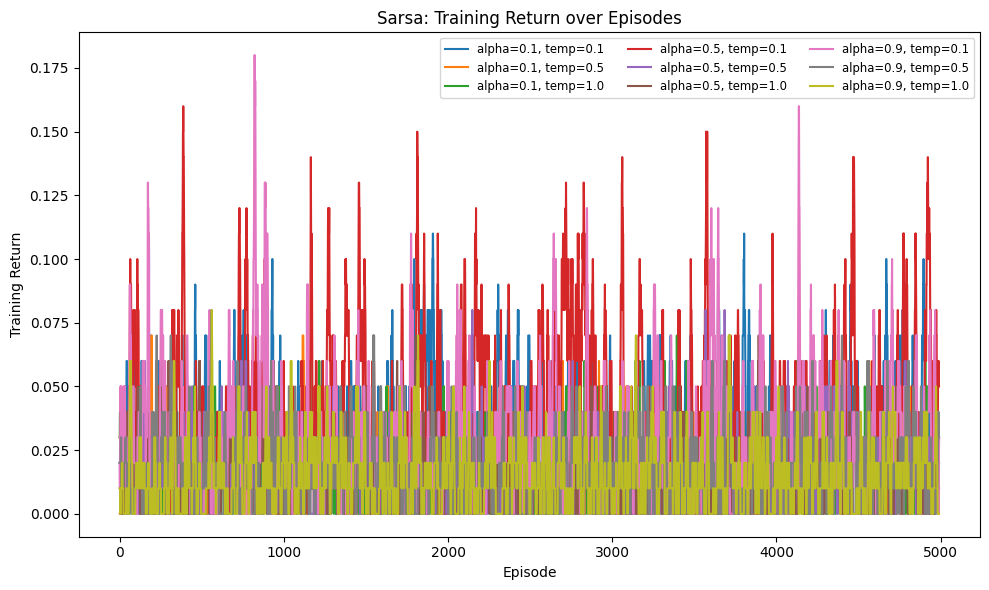

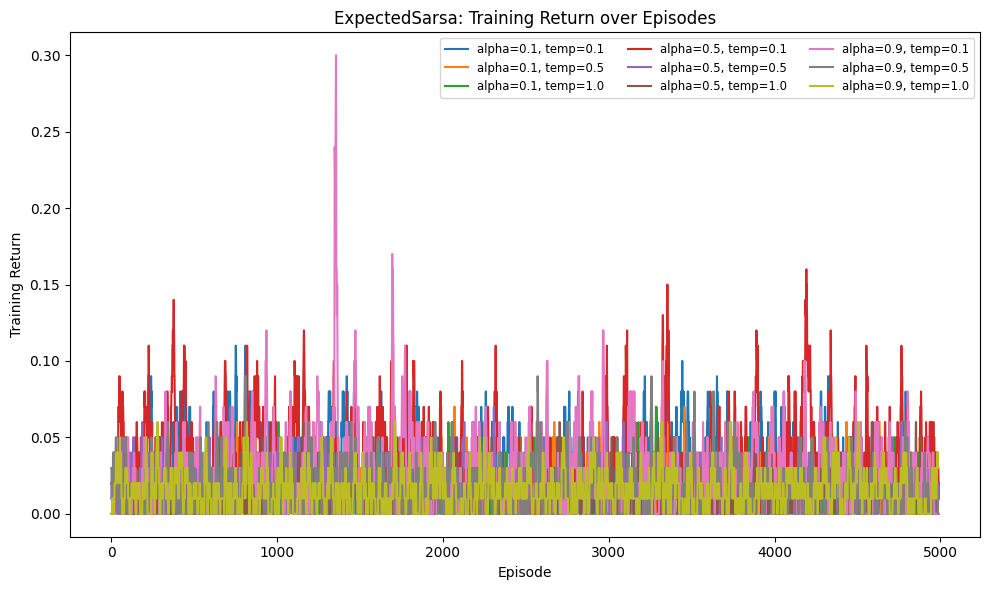

In [20]:
# Graph 3: Training return vs segments (9 lines for each combination)
for alg_name in algorithms.keys():
    plt.figure(figsize=(10,6))
    for alpha in alphas:
        for temp in temps:
            label = f'alpha={alpha}, temp={temp}'
            all_train = np.array(results[alg_name][(alpha, temp)]['all_train']).flatten()
            # perform moving average
            window_size = 10
            smoothed_train = np.convolve(all_train, np.ones(window_size)/window_size, mode='valid')
            plt.plot(smoothed_train, label=label)
    plt.xlabel('Episode')
    plt.ylabel('Training Return')
    plt.title(f'{alg_name}: Training Return over Episodes')
    plt.legend(fontsize='small', ncol=3)
    plt.tight_layout()
    plt.show()


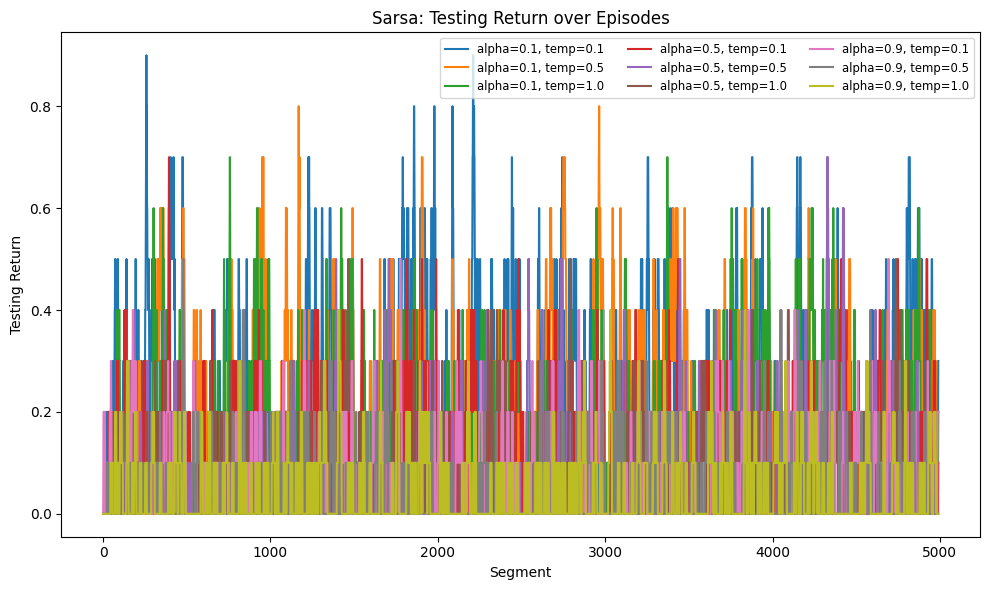

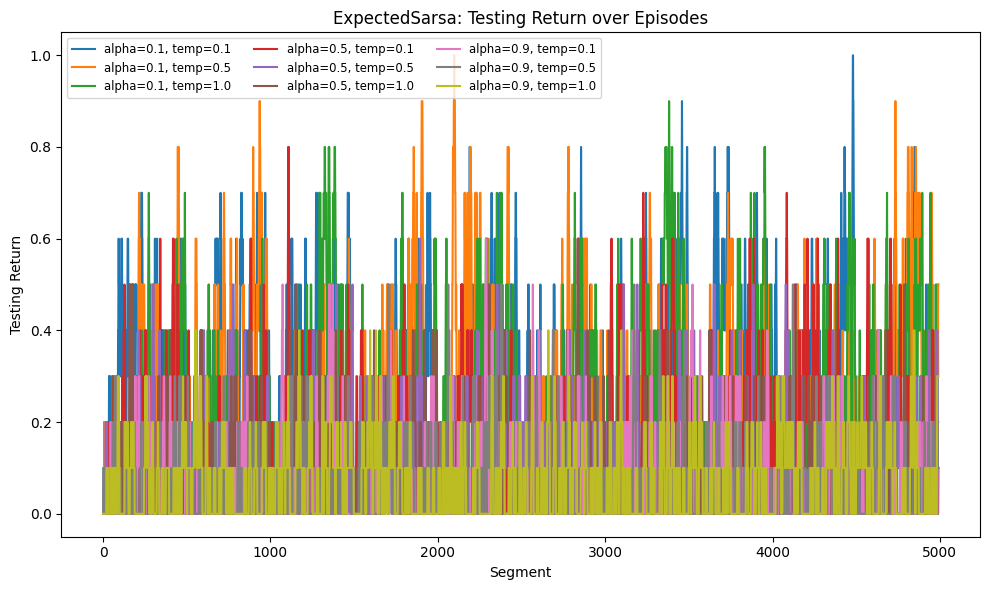

In [21]:
# Graph 4: Testing return vs segments (greedy policy)
for alg_name in algorithms.keys():
    plt.figure(figsize=(10,6))
    for alpha in alphas:
        for temp in temps:
            label = f'alpha={alpha}, temp={temp}'
            all_test = np.array(results[alg_name][(alpha, temp)]['all_test']).flatten()
            # perform moving average
            window_size = 10
            smoothed_train = np.convolve(all_test, np.ones(window_size)/window_size, mode='valid')
            plt.plot(smoothed_train, label=label)
    plt.xlabel('Episode')
    plt.xlabel('Segment')
    plt.ylabel('Testing Return')
    plt.title(f'{alg_name}: Testing Return over Episodes')
    plt.legend(fontsize='small', ncol=3)
    plt.tight_layout()
    plt.show()


## Report

### Experiment

The previous experiment tests the effect of various hyperparameters on the SARSA and ExpectedSARSA algorithms, and compares the performance of these two algorithms.

All of the results were obtained on the FrozenLake environment provided by the Gym framework. Each set of hyperparameters (choice of algorithm, temperature, and learning rate) was run for a total of 10 trials. Each trial consists of 500 segments, where one segment has 10 training episodes and one testing episode. Therefore, each trial contains 5000 training episodes and was evaluated 500 times throughout training.

### Choice of Parameters

The hyperparameters which were varied include the choice of algorithm, the learning rate (alpha), and the temperature. The values for the learning rate were selected between 0 and 1, with 0.5 as the midpoint and 0.9 and 0.1 to represent the more extreme learning rate values. The temperature was also chosen to be between 0 and 1, with 0.5 as the midpoint and 0.1 and 1 as the extreme values, similar to the learning rate. The discount factor, as specified in Ed Discussions, was fixed at 1.0.

### Conclusions

- **Effect of Alpha:**  
  - In both SARSA and ExpectedSARSA, the final training return is highly dependent on the learning rate. However, the trends are inconsistent across different temperatures.  
  - SARSA shows a clear peak at alpha = 0.5 with lower performance at both extremes, particularly for temperature = 0.1.  
  - ExpectedSARSA does not show a clear optimal alpha, different temperatures result in varying trends. At temperature = 0.1, alpha = 0.1 achieves the highest final return, but at lower temperatures, the trend is less clear.  

- **Effect of Temperature:**  
  - Lower temperatures generally lead to better final training returns, particularly for SARSA.  
  - For ExpectedSARSA, the best-performing temperature varies with alpha. However, a high temperature (1.0) tends to underperform across the board.  
  - SARSA's best performance occurs at a low temperature (temperature = 0.1, alpha = 0.1). In contrast, ExpectedSARSA shows a more mixed trend.  

- **Comparison Between SARSA and ExpectedSARSA:**  
  - SARSA achieves slightly higher peak performance than ExpectedSARSA in some cases.  
  - ExpectedSARSA appears more stable across different parameter settings but does not always reach the same peak performance as SARSA.  
  - Both algorithms show strong dependence on hyperparameters, meaning performance is sensitive to tuning.  

- **Training Return Trends:**  
  - The per-episode training return graph shows high variance across episodes, with noticeable fluctuations.  
  - There is no clear indication of convergence to a steady return, suggesting that either more training or a different learning strategy may be required to stabilize results.  

Overall, SARSA achieves better performance in some cases, but ExpectedSARSA exhibits more consistent behavior. Temperature and learning rate tuning are critical, with alpha between 0.1 and 0.5 and temperature at 0.1 generally being the best-performing settings.


# MDP Analysis

## Policy Evaluation

a)
The Bellman equation for the given MDP and policy is:

`v(s1) = R(s1, π(s1)) + γ·(P(s2|s1, a1)·v(s2) + P(s3|s1, a1)·v(s3))`

which simplifies to:

`v(s1) = R(s1, a1) + γ·v(s2) = 2 + 0.9 · v(s2)`

Similarly, for `v(s2)`:

`v(s2) = 1 + 0.9·v(s3)`

`v(s3) = 0`

Setting this up as a matrix, we have:
```
[ 1 -0.9  0  ]
[ 0   1 -0.9 ] x [v1, v2, v3]^T = [2, 1, 0]^T
[ 0   0   1  ]
```
By matrix inversion:
```
[2][ 1 -0.9  0  ]^-1
[1][ 0   1 -0.9 ] = [v1, v2, v3]^T
[0][ 0   0   1  ]
```
Solving the matrix inversion, we get:
```
v(s1) = 2.9
v(s2) = 1
```
b)
The numerical updates will be done with Python below:


In [23]:
states = ["s1", "s2", "s3"]
actions = ["a1", "a2"]
transitions = {
    "s1": {
        "a1":
         {
            "s1": 0,
            "s2": 1,
            "s3": 0,
            "done": 0
        },
        "a2":
        {
            "s1": 0,
            "s2": 0,
            "s3": 1,
            "done": 0
        }
    },
    "s2": {
        "a1":
         {
            "s1": 0,
            "s2": 0,
            "s3": 1,
            "done": 0
        },
        "a2":
         {
            "s1": 1,
            "s2": 0,
            "s3": 0,
            "done": 0
        }
    },
    "s3": {
        "a1":
         {
            "s1": 0,
            "s2": 0,
            "s3": 0,
            "done": 1
        },
        "a2":
        {
            "s1": 0,
            "s2": 0,
            "s3": 0,
            "done": 1
        }
    }
}
rewards = {
    "s1":
    {
        "a1": 2,
        "a2": 5
    },
    "s2":
    {
        "a1": 1,
        "a2": -1
    },
    "s3":
    {
        "a1": 0,
        "a2": 0
    }
}

In [24]:
gamma = 0.9
convergence_thresh = 1e-6

policy = lambda state: "a1"

values = {s: 0 for s in states}

while True:
    delta = 0

    new_values = values.copy()

    for s in states:
        a = policy(s)
        new_value = rewards[s][a] + gamma * sum(transitions[s][a][s_next] * values[s_next] for s_next in states)
        new_values[s] = new_value

        delta = max(delta, abs(new_value - values[s]))

    values = new_values

    if delta < convergence_thresh:
        break

print(f"Value of s1: {values['s1']}, Value of s2: {values['s2']}")

Value of s1: 2.9, Value of s2: 1.0


## Finding the Optimal Policy

a)
The Bellman optimality equations for the given MDP are:
```
v*(s1) = max(
  R(s1,a1) + γ·(P(s1|s1, a1)·v*(s1) + P(s2|s1, a1)·v*(s2) + P(s3|s1, a1)·v*(s3)),
  R(s1,a2) + γ·(P(s1|s1, a2)·v*(s1) + P(s2|s1, a2)·v*(s2) + P(s3|s1, a2)·v*(s3))
)

v*(s2) = max(
  R(s2,a1) + γ·(P(s1|s2, a1)·v*(s1) + P(s2|s2, a1)·v*(s2) + P(s3|s2, a1)·v*(s3)),
  R(s2,a2) + γ·(P(s1|s2, a2)·v*(s1) + P(s2|s2, a2)·v*(s2) + P(s3|s2, a2)·v*(s3))
)

v*(s3) = max(
  R(s3,a1) + γ·(P(s1|s3, a1)·v*(s1) + P(s2|s3, a1)·v*(s2) + P(s3|s3, a1)·v*(s3)),
  R(s3,a2) + γ·(P(s1|s3, a2)·v*(s1) + P(s2|s3, a2)·v*(s2) + P(s3|s3, a2)·v*(s3))
)
```
these simplify to:
```
v*(s1) = max(
  2 + 0.9·(0 + 1·v*(s2) + 0),
  5 + 0.9·(0 + 0 + 1·v*(s3))
)

v*(s2) = max(
  1 + 0.9·(0 + 0 + 1·v*(s3)),
  -1 + 0.9·(1·v*(s1) + 0 + 0)
)

v*(s3) = 0
```
Again, simplifying based on the value of `v*(s3)`:
```
v*(s1) = max(2 + 0.9·v*(s2), 5)
v*(s2) = max(1, -1 + 0.9·v*(s1))
```

Let's assume that `2 + 0.9·v*(s2) < 5`:

In this case, `v*(s1) = 5`.

For this case to be possible, `v*(s2)` must satisfy: `v*(s2) < 3/0.9` i.e. `v*(s2) < 3.333...`

Substituting `v*(s1)` into `v*(s2)`:

`v*(s2) = max(1, -1 + 0.9·5) = 3.5`

`v*(s2)` does not satisfy our previous condition that `v*(s2) < 3.333...`

Therefore, this case is invalid, meaning that we must have `2 + 0.9·v*(s2) >= 5`.

So, `v*(s2)` must satisfy: `v*(s2) >= 3.333...` Which means that `v*(s2)=1` would be an invalid value for `v*(s2)`. Therefore, it must be true that `1 <= -1 + 0.9·v*(s1)`.

Thus, we have:

`v*(s1) = 2 + 0.9·v*(s2)`

`v*(s2) = -1 + 0.9·v*(s1)`

Again, we can set this up as a matrix:
```
[1, -0.9][v*(s1)]     [2]
[-0.9, 1][v*(s2)]  =  [-1]

```
Solving this matrix system gives the solutions:
`v*(s1) = 5.7894736842105263157`
`v*(s2) = 4.2105263157894736842`


In [28]:
gamma = 0.9  # Discount factor
theta = 1e-10  # Convergence threshold

values = {s: 0 for s in states}  # Initialize values
policy = {s: None for s in states}  # Initialize policy

while True:
    delta = 0
    new_values = values.copy()

    for s in states:
        best_value = -99999
        best_action = None

        for a in actions:
            q_value = rewards[s][a] + gamma * sum(transitions[s][a][s_next] * values[s_next] for s_next in states)
            if q_value > best_value:
                best_value = q_value
                best_action = a

        delta = max(delta, abs(best_value - values[s]))
        new_values[s] = best_value
        policy[s] = best_action

    values = new_values
    if delta < theta:
        break

print(f"Optimal values: {values}")
print(f"Optimal policy: {policy}")

Optimal values: {'s1': 5.789473683759374, 's2': 4.2105263153834365, 's3': 0.0}
Optimal policy: {'s1': 'a1', 's2': 'a2', 's3': 'a1'}
